In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


plt.style.use('ggplot')

In [2]:
from versatileorbits import *
import masks

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal


from RealNVP_layer import RealNVP_Layer
import masks

class RealNVP(nn.Module):
    def __init__(self, input_output_size, hidden_size=12, num_layers = 3):
        super(RealNVP, self).__init__()

        self.input_output_size = input_output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #save masks in a parameterlist so they can be saved with the model for reference
        self.masks = nn.ParameterList([nn.Parameter(torch.Tensor(mask), requires_grad=False) for mask in masks.mask2(self.input_output_size, self.num_layers)])

        self.layers = nn.ModuleList([RealNVP_Layer(mask,self.input_output_size,self.hidden_size) for mask in self.masks])


        self.normal_distribution = MultivariateNormal(torch.zeros(self.input_output_size), torch.eye(self.input_output_size))

    def forward(self, x):
        output = x
        log_probability = 0
        for layer in self.layers:
            output, log_det_jacobian = layer(output)
            log_probability += log_det_jacobian
        

        return output, log_probability

    def forward_sample(self, num_samples):
        inputs = self.normal_distribution.sample((num_samples,))
        log_probability = self.normal_distribution.log_prob(inputs)

        outputs = inputs
        for layer in self.layers:
            outputs, log_det_jacobian = layer(outputs)
            log_probability += log_det_jacobian
        

        return outputs, log_probability

    def log_probability(self, y):
        """
        param y: (batch_size, input_output_size) array
        """
        batch_size, _ = y.shape
        log_probability = torch.zeros(batch_size)

        for layer in reversed(self.layers):
            #print("layer, new y =", y[:5])
            y, inverse_log_det_jacobian = layer.inverse(y)
            log_probability += inverse_log_det_jacobian
        
        log_probability += self.normal_distribution.log_prob(y)

        return log_probability

In [6]:
def train(model, num_epochs = 100, batch_size = 64):
    NF_dataset = OrbitsDataset_NF_train(num_samples = 1000, phi0 = 1, H = -0.3, L = 0.5)
    train_loader = torch.utils.data.DataLoader(NF_dataset, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    for epoch in tqdm(range(num_epochs)):    
        epoch_loss = 0
        for orbit_position in train_loader:
            log_probability = model.log_probability(orbit_position) #(batch_size)
            loss = - torch.mean(log_probability, dim = 0)
            
            
            loss.backward()
            optimizer.step()
            model.zero_grad()
            
            epoch_loss += loss
            
        
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss.detach())
    
    return model, losses


In [8]:
#model = RealNVP(masks_nf, hidden_size)
model = RealNVP(input_output_size = 4, hidden_size = 32)

model, losses = train(model, num_epochs = 100)

100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


In [9]:
print([loss.item() for loss in losses])

[6.989358901977539, 6.051713943481445, 5.365544319152832, 4.663014888763428, 3.9016706943511963, 3.076193332672119, 2.2577383518218994, 1.5617374181747437, 1.2027291059494019, 1.0087864398956299, 0.8737899661064148, 0.7424572110176086, 0.5967315435409546, 0.43295609951019287, 0.29525139927864075, 0.17961055040359497, 0.13903173804283142, 0.04372170567512512, 0.020449882373213768, -0.056938737630844116, -0.123724564909935, -0.17157375812530518, -0.2021806389093399, -0.23604750633239746, -0.2582766115665436, -0.282436341047287, -0.307792067527771, -0.32836341857910156, -0.34012967348098755, -0.35507437586784363, -0.37501466274261475, -0.39076727628707886, -0.39293351769447327, -0.40155795216560364, -0.41875651478767395, -0.4267158806324005, -0.41701826453208923, -0.407985657453537, -0.44337981939315796, -0.4670054018497467, -0.4581134617328644, -0.4517025947570801, -0.4555166959762573, -0.4726703464984894, -0.4933532774448395, -0.49720457196235657, -0.4893137514591217, -0.486266195774078

In [10]:
outputs, log_probability = model.forward_sample(500)

In [11]:
print(outputs.shape)
print(log_probability[:5])
print(outputs[:5])

torch.Size([500, 4])
tensor([-11.9102, -11.2177, -13.8147, -10.2402,  -8.8962],
       grad_fn=<SliceBackward0>)
tensor([[-0.4425,  0.3991, -2.8871, -1.0242],
        [-1.1073, -2.4851,  0.3312,  0.1624],
        [-1.3780, -2.7069,  0.2199,  0.2300],
        [-1.5227, -2.7622,  0.1163, -0.1387],
        [ 0.2128, -0.7795,  0.3794,  1.4070]], grad_fn=<SliceBackward0>)


In [12]:
detached_outputs = outputs.detach().numpy()

In [16]:
torch.save(detached_outputs, 'storedTensors/detached_outputs_500.pt')

In [17]:
detached_outputs_load = torch.load('storedTensors/detached_outputs_500.pt')

In [18]:
print(detached_outputs_load[:5,0])

[-0.44252557 -1.1072668  -1.3780439  -1.5226684   0.2128189 ]


[(-5.0, 5.0), (-5.0, 5.0)]

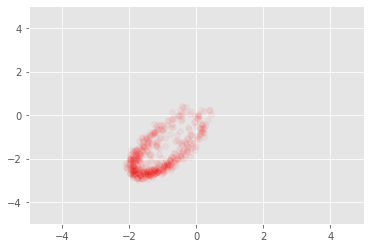

In [19]:
fig, ax = plt.subplots()
ax.scatter(detached_outputs_load[:,0], detached_outputs_load[:,1], alpha=.05, c='red')
ax.set(xlim=(-5, 5), ylim=(-5, 5))

[(-5.0, 5.0), (-5.0, 5.0)]

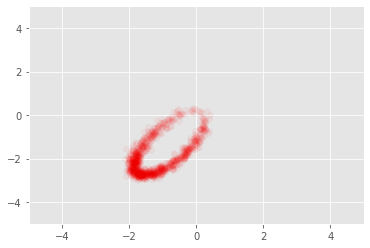

In [20]:
fig, ax = plt.subplots()
train_dataset = OrbitsDataset_NF_train(num_samples = 1000, H = -0.3, L = 0.5, phi0 = 1)   
ax.scatter(train_dataset.data[:,0], train_dataset.data[:,1], alpha=.05, c='red')
ax.set(xlim=(-5, 5), ylim=(-5, 5))